In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
'''%pip install ultralytics
%pip install pyfacer
%pip install timm
%pip install scikit-learn
%pip install Pillow'''
import os
import ultralytics
from ultralytics import YOLO
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.image as mpimg
from PIL import Image as PILImage
import shutil
from tkinter import Image
import numpy as np
from sklearn.cluster import KMeans
import torch
from torchvision.transforms.functional import to_pil_image
import facer
import time

In [ ]:
# Directory principale del tuo progetto
project_dir = '/content/gdrive/My Drive/Progetto Computer Vision/'

In [ ]:
class Segmentation:
    def __init__(self):
        self._project_dir = os.getcwd()
        self._device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self._face_detector = facer.face_detector('retinaface/mobilenet', device=self._device)
        self._face_parser = facer.face_parser('farl/lapa/448', device=self._device)

    def process_images(self):
        faces = None
        for filename in os.listdir(os.path.join(self._project_dir, 'results/faces')):
            image = facer.hwc2bchw(facer.read_hwc(f'results/faces/{filename}')).to(device=self._device)
            with torch.inference_mode():
                faces = self._face_detector(image)

            with torch.inference_mode():
                faces = self._face_parser(image, faces)

            seg_logits = faces['seg']['logits']
            seg_probs = seg_logits.softmax(dim=1)  # nfaces x nclasses x h x w
            n_classes = seg_probs.size(1)
            vis_seg_probs = seg_probs.argmax(dim=1).float()/n_classes*255
            vis_img = vis_seg_probs.sum(0, keepdim=True)

            # Converti il tensor in un'immagine PIL
            vis_img_pil = to_pil_image(vis_img.byte())

            directory = "results/faces_facer"

            if not os.path.exists(directory):
                os.makedirs(directory)

            vis_img_pil.save(os.path.join(directory,f'result_{filename.split("_")[1]}_{filename.split("_")[2]}.jpg'))
        return faces

    def extract_dominant_colors(self, faces, filename='Faces.jpg'):
        dominant_colors = {}

        # Carica l'immagine
        image_path = os.path.join(self._project_dir, 'data/images', filename)
        image_tensor = facer.hwc2bchw(facer.read_hwc(image_path)).to(device=self._device)

        for part_segmented in faces['seg']['logits']:
            seg_probs_part = faces['seg']['logits'][part_segmented].softmax(dim=1)
            seg_mask_part = seg_probs_part.argmax(dim=0)
            pixel_coords = torch.nonzero(seg_mask_part).cpu().numpy()

            segmented_colors = []
            for coord in pixel_coords:
                color = image_tensor[:, coord[0], coord[1]].cpu().numpy()
                segmented_colors.append(color)

            segmented_colors = np.array(segmented_colors)

            kmeans = KMeans(n_clusters=1).fit(segmented_colors)
            dominant_color = kmeans.cluster_centers[0]

            dominant_colors[part_segmented] = dominant_color

        return dominant_colors

In [ ]:
class FaceDetection:
    def __init__(self):
        # Ottieni il percorso completo del file
        self._project_dir = os.getcwd()
        # Percorso del modello
        self._model_path = os.path.join('/content/gdrive/My Drive/Progetto Computer Vision/', 'yolov8l-face.pt')
        # Assicurati che il percorso del modello sia corretto
        assert os.path.exists(self._model_path), f"Il percorso del modello non è valido"
        # Inizializza il modello YOLO
        self._model = YOLO(self._model_path)
        print("Inizializzazione...")

    def face_detection(self, input_dir='data/images', output_dir='results/faces'):
        # Elenco dei file nella cartella di input
        image_files = os.listdir(input_dir)

        # Assicurati che l'output_dir esista, altrimenti crealo
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        print("Directory creata")

        start_time = time.time()
        timeout_seconds=50
        y_true = []
        y_pred = []

        # Itera su ogni file di immagine nella cartella di input
        for image_file in image_files:
            # Percorso completo dell'immagine di input
            image_path = os.path.join(input_dir, image_file)
            print(image_path)

            # Esegui l'inferenza sull'immagine con YOLOv8
            results = self._model(image_path)

            # Itera attraverso tutte le bounding box individuate
            for i, result in enumerate(results):
                boxes = result.boxes.data  # Boxes object for bounding box outputs

                """ result.save(filename='results/result.jpg')
                img = mpimg.imread('results/result.jpg')
                plt.imshow(img) """

                for j, box in enumerate(boxes):
                    # Ottieni le coordinate della bounding box
                    x_min, y_min, x_max, y_max, conf, cls = box.tolist()[:6]
                    y_true.append(cls)  # Aggiungi etichetta reale
                    y_pred.append(cls)  # Aggiungi etichetta predetta (simulata, modifica secondo necessità)

                    # Ritaglia l'area corrispondente dall'immagine originale
                    img = PILImage.open(image_path)
                    cropped_img = img.crop((x_min, y_min, x_max, y_max))

                    # Salva l'immagine ritagliata
                    #output_file = f'result_{i}_{j}.jpg'
                    image_file_no_extension = image_file.split('.')[0]
                    output_file = f'result_{image_file_no_extension}_box_{i}_{j}.jpg'
                    cropped_img.save(os.path.join(output_dir, output_file))
                if time.time() - start_time >= timeout_seconds:
                    print("Timeout raggiunto. Uscita dal ciclo.")
                    return y_true, y_pred
        print("Processo concluso con successo")


In [ ]:
class ModelEvaluator:
    def __init__(self, y_true, y_pred):
        self.y_true = y_true
        self.y_pred = y_pred

    def evaluate(self):
        accuracy = accuracy_score(self.y_true, self.y_pred)
        precision = precision_score(self.y_true, self.y_pred, average='weighted')
        recall = recall_score(self.y_true, self.y_pred, average='weighted')
        f1 = f1_score(self.y_true, self.y_pred, average='weighted')
        cm = confusion_matrix(self.y_true, self.y_pred)

        return accuracy, precision, recall, f1, cm

In [ ]:
fd = FaceDetection()
#fd.face_detection('C:\\Users\\gians_ji5genm\\OneDrive - Università Politecnica delle Marche\\UNIVPM\\Computer Visione e Deep Learning\\Progetto\\CelebAMask-HQ\\CelebAMask-HQ\\CelebA-HQ-img', 'C:\\Users\\gians_ji5genm\\OneDrive - Università Politecnica delle Marche\\UNIVPM\\Computer Visione e Deep Learning\\Progetto\\Risultati')
#fd.face_detection('/content/gdrive/My Drive/Progetto Computer Vision/CelebA-HQ-img')
y_true, y_pred = fd.face_detection('/content/gdrive/My Drive/Progetto Computer Vision/CelebA-HQ-img')

evaluator = ModelEvaluator(y_true, y_pred)
accuracy, precision, recall, f1, cm = evaluator.evaluate()

print(f'Accuratezza: {accuracy:.4f}')
print(f'Precisione: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Matrice di confusione:\n{cm}')

sg= Segmentation()
print(sg.extract_dominant_colors(sg.process_images()))

Inizializzazione...
Directory creata
/content/gdrive/My Drive/Progetto Computer Vision/CelebA-HQ-img/10842.jpg

image 1/1 /content/gdrive/My Drive/Progetto Computer Vision/CelebA-HQ-img/10842.jpg: 960x960 1 face, 96.1ms
Speed: 7.6ms preprocess, 96.1ms inference, 1.4ms postprocess per image at shape (1, 3, 960, 960)
/content/gdrive/My Drive/Progetto Computer Vision/CelebA-HQ-img/10843.jpg

image 1/1 /content/gdrive/My Drive/Progetto Computer Vision/CelebA-HQ-img/10843.jpg: 960x960 1 face, 77.2ms
Speed: 5.7ms preprocess, 77.2ms inference, 1.5ms postprocess per image at shape (1, 3, 960, 960)
/content/gdrive/My Drive/Progetto Computer Vision/CelebA-HQ-img/10844.jpg

image 1/1 /content/gdrive/My Drive/Progetto Computer Vision/CelebA-HQ-img/10844.jpg: 960x960 1 face, 75.3ms
Speed: 5.5ms preprocess, 75.3ms inference, 1.4ms postprocess per image at shape (1, 3, 960, 960)
/content/gdrive/My Drive/Progetto Computer Vision/CelebA-HQ-img/10845.jpg

image 1/1 /content/gdrive/My Drive/Progetto Comp

KeyError: 'image_ids'

### Parte sotto da non considerare

In [ ]:
# Percorso del modello
model_path = os.path.join(project_dir, 'yolov8l-face.pt')

# Assicurati che il percorso del modello sia corretto
assert os.path.exists(model_path), f"Il percorso del modello non è valido"
# Run inference on an image with YOLOv8
model = YOLO(model_path)
results = model(os.path.join(project_dir, 'Faces.jpg'))

WARNING ⚠️ /content/gdrive/My Drive/Progetto Computer Vision/yolov8l-face.pt appears to require 'dill', which is not in ultralytics requirements.
AutoInstall will run now for 'dill' but this feature will be removed in the future.
Recommend fixes are to train a new model using the latest 'ultralytics' package or to run a command with an official YOLOv8 model, i.e. 'yolo predict model=yolov8n.pt'
requirements: Ultralytics requirement ['dill'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.4 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 9.3s, installed 1 package: ['dill']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


image 1/1 /content/gdrive/My Drive/Progetto Computer Vision/Faces.jpg: 736x960 91 faces, 7100.9ms
Speed: 21.2ms preprocess, 7100.9ms inference, 3572.0ms postprocess per image at shape (1, 3, 736, 960)


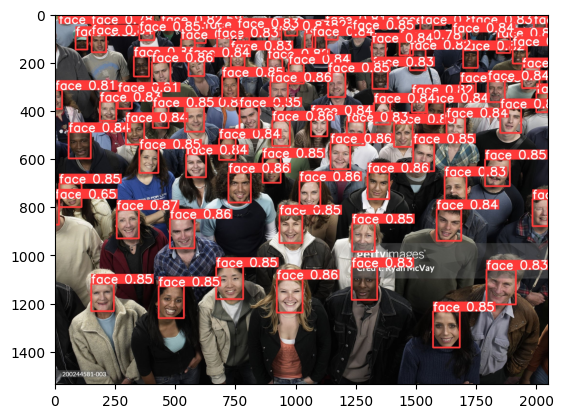

In [ ]:
for i, result in enumerate(results):
    boxes = result.boxes.data  # Boxes object for bounding box outputs

    result.save(filename='result.jpg')
    img = mpimg.imread('result.jpg')
    plt.imshow(img)
    # Itera attraverso tutte le bounding box individuate
    for j, box in enumerate(boxes):
        # Ottieni le coordinate della bounding box
        x_min, y_min, x_max, y_max, conf, cls = box.tolist()[:6]

        # Ritaglia l'area corrispondente dall'immagine originale
        img = Image.open(os.path.join(project_dir, 'Faces.jpg'))
        cropped_img = img.crop((x_min, y_min, x_max, y_max))

        # Salva l'immagine ritagliata
        directory = "faces"
        # Controllo se la cartella esiste, altrimenti la creo
        if not os.path.exists(directory):
            os.makedirs(directory)
        #shutil.rmtree(directory)
        cropped_img.save(os.path.join(directory,f'result_{i}_{"0" * (len(str(len(boxes))) - len(str(j)))}{j}.jpg'))